In [1]:
import itertools
import subprocess

import numpy as np

import ad3

In [2]:
# Graph vizualizer with dot
# inspired by NLTK (License: Apache 2.0, Copyright (C) 2001-2016 NLTK Project), but slightly more general

class DepGraph(object):
    def __init__(self, labels, links):
        self.labels = labels
        self.links = links

    def _repr_svg_(self):
        # Start the digraph specification
        head = """\
digraph G{
edge [dir=forward]
node [shape=plaintext]"""

        lbl_code = ['{} [label="{}"]'.format(k, w)
                    for k, w in enumerate(self.labels)]

        link_code = ['{} -> {}'.format(*link) for link in self.links]

        dot_string = "\n".join([head] + lbl_code + link_code + ["}"])
        
        try:
            process = subprocess.Popen(
                ['dot', '-Tsvg'],
                stdin=subprocess.PIPE,
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                universal_newlines=True,
            )
        except OSError:
            raise Exception('Cannot find the dot binary from Graphviz package')
        out, err = process.communicate(dot_string)
        if err:
            raise Exception(
                'Cannot create svg representation by running dot from string: {}'
                ''.format(dot_string))
        
        return out

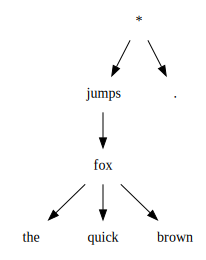

In [3]:
DepGraph("* the quick brown fox jumps .".split(),
         [(4, 1), (4, 2), (4, 3), (5, 4), (0, 5), (0, 6)])
         

3 sentences at once, fully connected components

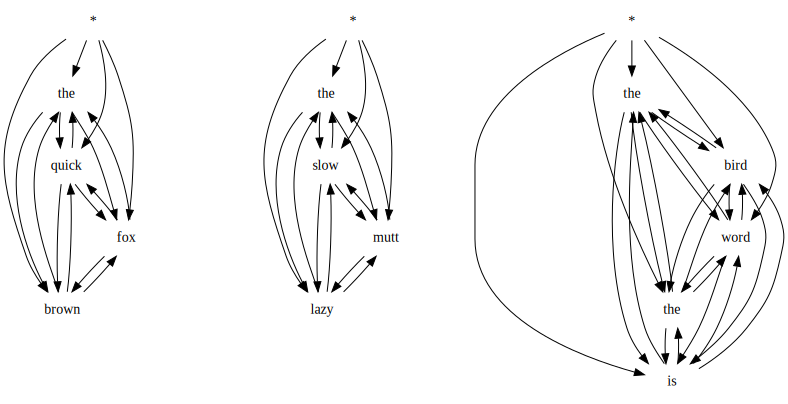

In [4]:
sentences = ["* the quick brown fox".split(),
             "* the slow lazy mutt".split(),
             "* the bird is the word".split()]

words = [w for sent in sentences for w in sent]
n_words = [len(sent) for sent in sentences]
offset = np.append([0], np.cumsum(n_words)[:-1])


link_ix = []
links_by_sent = []

for sent_offset, sent_len in zip(offset, n_words):
    sent_links = []
    for head in range(sent_len):
        for mod in range(1, sent_len):
            if mod == head:
                continue

            sent_links.append((sent_offset + head,
                              sent_offset + mod))
    links_by_sent.append(sent_links)
    link_ix.extend(sent_links)

DepGraph(words, link_ix)

Single tree over all sentences

In [5]:
# rng = np.random.RandomState(0)

# fg = ad3.PFactorGraph()

# link_var = []

# for mod, head in link_ix:
#     var = fg.create_binary_variable()
#     var.set_log_potential(rng.uniform(-1, 1))
#     link_var.append(var)

# tree_f = ad3.factor_graph.PFactorTree()
# fg.declare_factor(tree_f, link_var, True)
# tree_f.initialize(len(words), link_ix)

# fg.set_eta_ad3(.1)
# fg.adapt_eta_ad3(True)
# fg.set_max_iterations_ad3(1000)
# value, marginals, edge_marginals, value = fg.solve_lp_map_ad3()

# pred_links = [link for link, posterior in zip(link_ix, marginals)
#               if posterior > 0.1]

# DepGraph(words, pred_links)

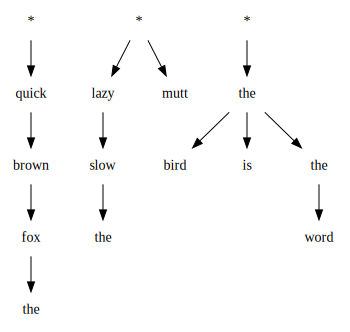

In [7]:
rng = np.random.RandomState(0)

fg = ad3.PFactorGraph()

link_var = []

for subgraph_ix, sent_offset, sent_len in zip(links_by_sent, offset, n_words):
    sent_vars = []
    adjusted_subgraph = []
    for mod, head in subgraph_ix:
        var = fg.create_binary_variable()
        var.set_log_potential(rng.uniform(-1, 1))
        sent_vars.append(var)
        adjusted_subgraph.append((mod - sent_offset, head - sent_offset))

    tree_f = ad3.factor_graph.PFactorTree()
    fg.declare_factor(tree_f, sent_vars, True)
    tree_f.initialize(sent_len, adjusted_subgraph)
    

fg.set_eta_ad3(.1)
fg.adapt_eta_ad3(True)
fg.set_max_iterations_ad3(1000)
value, marginals, edge_marginals, value = fg.solve_lp_map_ad3()

pred_links = [link for link, posterior in zip(link_ix, marginals)
              if posterior > 0.1]

DepGraph(words, pred_links)

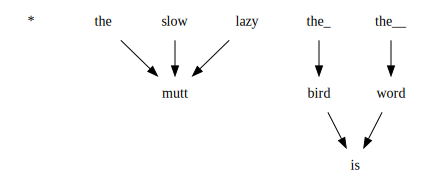

In [82]:
POS = +1
NEG = -1

from collections import defaultdict

words = "* the slow lazy mutt the_ bird is the__ word".split()

link_ix = []

for mod in range(1, len(words)):
    for head in range(len(words)):
        if mod == head:
            continue

        # link_ix.append((head, mod))
        link_ix.append((mod, head))
        
scores = defaultdict(lambda: NEG)

scores['mutt', 'the'] = POS
scores['mutt', 'slow'] = POS
scores['mutt', 'lazy'] = POS

scores['is', 'bird'] = POS
scores['is', 'word'] = POS
scores['bird', 'the_'] = POS
scores['word', 'the__'] = POS

true_links = [link for link in link_ix if scores[words[link[1]], words[link[0]]] > 0]
DepGraph(words, true_links)

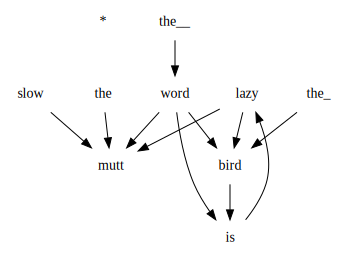

In [83]:
fg = ad3.PFactorGraph()

link_var = []

rng = np.random.RandomState(0)
for mod, head in link_ix:
    var = fg.create_binary_variable()
    
    z = scores[words[head], words[mod]]
    if head == 0:
        z = 0
    if z < 0.1 and rng.uniform() > 0.975:
        z = 0.01
    var.set_log_potential(z)
    link_var.append(var)

fg.set_eta_ad3(.1)
fg.adapt_eta_ad3(True)
fg.set_max_iterations_ad3(1000)
value, marginals, edge_marginals, value = fg.solve_lp_map_ad3()

pred_links = [link for link, posterior in zip(link_ix, marginals)
              if posterior > 0.1]

DepGraph(words, pred_links)

[0.0, 0.2914110429447897, 0.0, 0.41411042944785453, 0.20245398773006398, 0.0, 0.0, 0.2699386503067427, 0.0, 0.0, 0.08895705521472574, 0.0, 0.2699386503067427, 0.31595092024540283, 0.0, 0.0, 0.30061349693251627, 0.0, 0.0, 0.21165644171779055, 0.2699386503067427, 0.31595092024540283, 0.21165644171779055, 0.0, 0.0, 0.2269938650306771, 0.0, 0.0, 0.2269938650306771, 0.21165644171779055, 0.0, 0.2699386503067427, 0.0, 0.0, 0.20245398773006398, 0.0, 0.0, 0.2699386503067427, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5184049079754668, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20245398773006398, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.2269938650306771, 0.0, 0.0, 0.0, 0.0, 0.4815950920245332, 0.0]


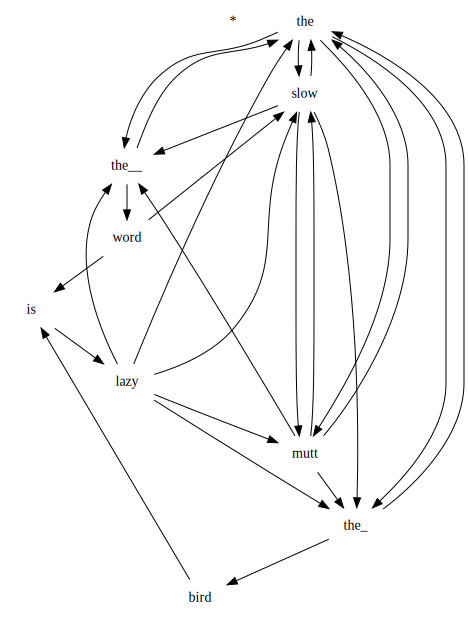

In [84]:
tree_f = ad3.factor_graph.PFactorTree()
fg.declare_factor(tree_f, link_var, True)
tree_f.initialize(len(words), link_ix)

fg.set_eta_ad3(.01)
fg.adapt_eta_ad3(True)
fg.set_max_iterations_ad3(10000)
value, marginals, edge_marginals, value = fg.solve_lp_map_ad3()

print(marginals)
pred_links = [link for link, posterior in zip(link_ix, marginals)
              if posterior > 0.01]

DepGraph(words, pred_links)